In [21]:
import numpy as np
import pandas as pd
from lifelines import KaplanMeierFitter, CoxPHFitter
import matplotlib.pyplot as plt

def simulate_data(n_subjects, max_time, censoring_rate_treated, censoring_rate_control):
    
    # Generate treatment assignment
    treatment = np.random.binomial(1, 0.5, n_subjects)
    
    # Generate event times (no true effect of treatment)
    event_times = np.random.exponential(scale=max_time/2, size=n_subjects)
    
    # Generate censoring times
    censoring_times_treated = np.random.exponential(scale=max_time/censoring_rate_treated, size=n_subjects)
    censoring_times_control = np.random.exponential(scale=max_time/censoring_rate_control, size=n_subjects)
    
    # Combine censoring times based on treatment
    censoring_times = np.where(treatment == 1, censoring_times_treated, censoring_times_control)
    
    # Determine observed times and event indicators
    observed_times = np.minimum(event_times, censoring_times)
    event_observed = (event_times <= censoring_times).astype(int)
    
    # Create DataFrame
    df = pd.DataFrame({
        'treatment': treatment,
        'time_to_event': observed_times,
        'MACE_event_observed': event_observed
    })
    
    return df

def run_simulation(n_simulations, n_subjects, max_time, censoring_rate_treated, censoring_rate_control):
    results = []
    
    for _ in range(n_simulations):
        df = simulate_data(n_subjects, max_time, censoring_rate_treated, censoring_rate_control)
        # Fit Cox model
        cph = CoxPHFitter()
        cph.fit(df, duration_col='time_to_event', event_col='MACE_event_observed')
        # Store results
        results.append({
            'hazard_ratio': cph.hazard_ratios_['treatment'],
            'p_value': cph.summary['p']['treatment']
        })
    
    return pd.DataFrame(results)


Mean Hazard Ratio: 1.007
Proportion of significant p-values (< 0.05): 0.060


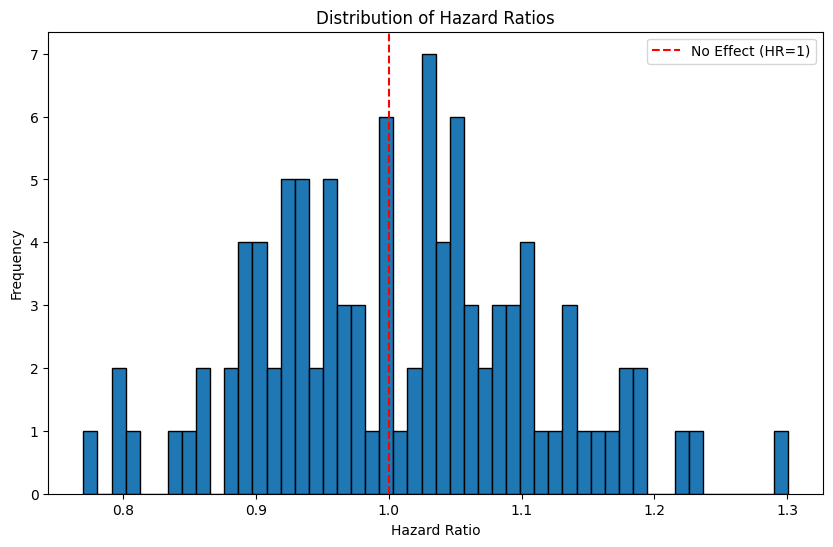

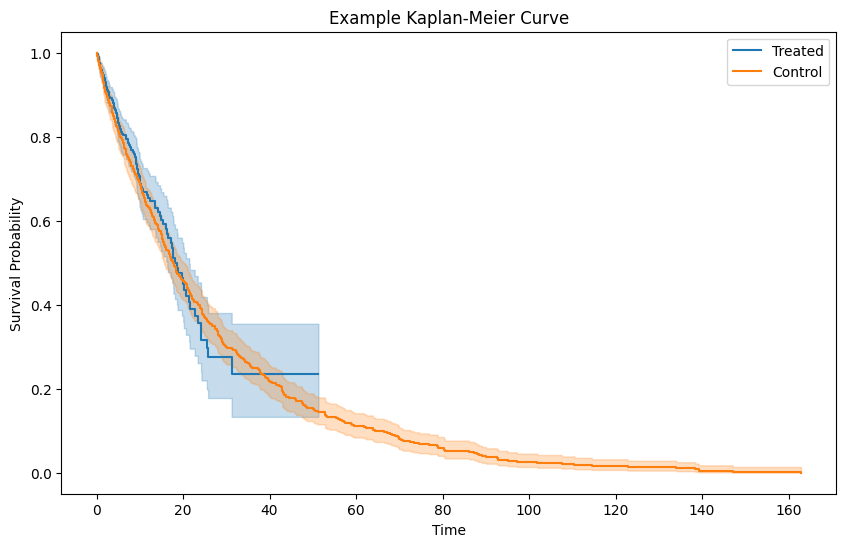

In [24]:
# Set simulation parameters
n_simulations = 100
n_subjects = 1000
max_time = 50  # months
censoring_rate_treated = 5 # Higher rate means more censoring
censoring_rate_control = 0.1  # Lower rate means less censoring

# Run simulation
results = run_simulation(n_simulations, n_subjects, max_time, censoring_rate_treated, censoring_rate_control)

# Analyze results
print(f"Mean Hazard Ratio: {results['hazard_ratio'].mean():.3f}")
print(f"Proportion of significant p-values (< 0.05): {(results['p_value'] < 0.05).mean():.3f}")
# Plot distribution of hazard ratios
plt.figure(figsize=(10, 6))
plt.hist(results['hazard_ratio'], bins=50, edgecolor='black')
plt.title('Distribution of Hazard Ratios')
plt.xlabel('Hazard Ratio')
plt.ylabel('Frequency')
plt.axvline(x=1, color='red', linestyle='--', label='No Effect (HR=1)')
plt.legend()
plt.show()

# Plot example Kaplan-Meier curve
df_example = simulate_data(n_subjects, max_time, censoring_rate_treated, censoring_rate_control)
kmf_treated = KaplanMeierFitter()
kmf_control = KaplanMeierFitter()

kmf_treated.fit(df_example[df_example['treatment']==1]['time_to_event'], 
                df_example[df_example['treatment']==1]['MACE_event_observed'], label='Treated')
kmf_control.fit(df_example[df_example['treatment']==0]['time_to_event'], 
                df_example[df_example['treatment']==0]['MACE_event_observed'], label='Control')

plt.figure(figsize=(10, 6))
kmf_treated.plot()
kmf_control.plot()
plt.title('Example Kaplan-Meier Curve')
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.show()